# Doing vectorization of headline and article separately in this notebook

In [1]:
import sys
import os
import string
import re
from tqdm import tqdm 
from collections import Counter

import pandas as pd
import numpy as np

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer, regexp_tokenize, word_tokenize
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.metrics.pairwise import cosine_similarity

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data

import matplotlib.pyplot as plt

from utils import dataset, generate_test_splits, score



In [ ]:
nltk.download()

### Using the included data importer

In [2]:
train_data = dataset.DataSet(name='train')
test_data = dataset.DataSet(name="competition_test") # there's no stances for the non-competition test data??  

Reading dataset
Total stances: 49972
Total bodies: 1683
Reading dataset
Total stances: 25413
Total bodies: 904


### Converting imported data into pandas dataframes

In [3]:
train_data_articles_df = pd.DataFrame({'Article': train_data.articles.values(), 'Body ID':train_data.articles.keys()} , index=train_data.articles.keys())
train_data_stances_df = pd.DataFrame(train_data.stances)

test_data_articles_df = pd.DataFrame({'Article': test_data.articles.values(), 'Body ID':test_data.articles.keys()} , index=test_data.articles.keys())
test_data_stances_df = pd.DataFrame(test_data.stances)

# checking out example output
print(train_data_articles_df['Article'][154] + '\n')
print(train_data_stances_df['Headline'][158] + '\n')
print(train_data_stances_df['Stance'][158])

Thousands of people have been duped by a fake news story claiming that Nasa has forecast a total blackout of earth for six days in December.

The story, entitled "Nasa Confirms Earth Will Experience 6 Days of Total Darkness in December 2014!" originated from Huzlers.com, a website well known for publishing fake stories with sensational headlines.

The bogus report read: "Nasa has confirmed that the Earth will experience 6 days of almost complete darkness and will happen from the dates Tuesday the 16 – Monday the 22 in December. The world will remain, during these three days, without sunlight due to a solar storm, which will cause dust and space debris to become plentiful and thus, block 90% sunlight.

"The head of Nasa Charles Bolden who made the announcement and asked everyone to remain calm. This will be the product of a solar storm, the largest in the last 250 years for a period of 216 hours total.

"Despite the six days of darkness soon to come, officials say that the earth will no

### Preprocessing: Tokenize and remove stopwords. 

More done later during vectorization when the dictionary size is cut short

probably more that can be done

TODO: put this all into importable utility functions so it can be put into the GUI

In [4]:
tokenizer = RegexpTokenizer(r'\b[^\d\W]+\b') # regex can be improved but idk
train_data_articles_df['article_cleaned'] = train_data_articles_df['Article'].apply(lambda x: tokenizer.tokenize(x.lower()))
train_data_stances_df['headline_cleaned'] = train_data_stances_df['Headline'].apply(lambda x: tokenizer.tokenize(x.lower()))

test_data_articles_df['article_cleaned'] = test_data_articles_df['Article'].apply(lambda x: tokenizer.tokenize(x.lower()))
test_data_stances_df['headline_cleaned'] = test_data_stances_df['Headline'].apply(lambda x: tokenizer.tokenize(x.lower()))


# remove_whitespace = r'\s+'
# train_data_articles_df['article_cleaned'] = train_data_articles_df['Article'].apply(lambda x: re.split(remove_whitespace, x))
# train_data_stances_df['headline_cleaned'] = train_data_stances_df['Headline'].apply(lambda x: re.split(remove_whitespace, x))

# exclude = r'[^/d/W]+'
# train_data_articles_df['article_cleaned'] = train_data_articles_df['article_cleaned'].apply(lambda x: re.findall(exclude, x))
# train_data_stances_df['headline_cleaned'] = train_data_stances_df['headline_cleaned'].apply(lambda x: re.findall(exclude, x))




In [5]:
print(train_data_stances_df['Headline'][154])
print(train_data_stances_df['headline_cleaned'][154])
print(train_data_stances_df['Stance'][154])

ISIS Video: America’s Air Dropped Weapons Now in Our Hands
['isis', 'video', 'america', 's', 'air', 'dropped', 'weapons', 'now', 'in', 'our', 'hands']
discuss


In [6]:
website_words = ['http', 'twitter', 'com', 'pic', 'co']
month_words = ['january', 'february', 'march', 'april', 'may', 'june', 'july', 'august', 'september', 'october', 'novemeber', 'december']
# TODO: think of more for these

my_banned_words = stopwords.words('english') + website_words + month_words


In [7]:
def remove_stopwords(string):
    output = []
    for word in string:
        if word not in my_banned_words:
            output.append(word)
    return output

train_data_articles_df['article_cleaned'] =  train_data_articles_df['article_cleaned'].apply(lambda x: remove_stopwords(x))
train_data_stances_df['headline_cleaned'] =  train_data_stances_df['headline_cleaned'].apply(lambda x: remove_stopwords(x))

test_data_articles_df['article_cleaned'] =  test_data_articles_df['article_cleaned'].apply(lambda x: remove_stopwords(x))
test_data_stances_df['headline_cleaned'] =  test_data_stances_df['headline_cleaned'].apply(lambda x: remove_stopwords(x))

In [8]:
# lemmatization
print(train_data_stances_df['headline_cleaned'][24])
lemmatizer = WordNetLemmatizer()
def lemmatize_tokens(string):
    output = []
    for word in string:
        output.append(lemmatizer.lemmatize(word))
    return output
    
train_data_articles_df['article_cleaned'] =  train_data_articles_df['article_cleaned'].apply(lambda x: lemmatize_tokens(x))
train_data_stances_df['headline_cleaned'] =  train_data_stances_df['headline_cleaned'].apply(lambda x: lemmatize_tokens(x))

test_data_articles_df['article_cleaned'] =  test_data_articles_df['article_cleaned'].apply(lambda x: lemmatize_tokens(x))
test_data_stances_df['headline_cleaned'] =  test_data_stances_df['headline_cleaned'].apply(lambda x: lemmatize_tokens(x))

print(train_data_stances_df['headline_cleaned'][24])


['net', 'extra', 'back', 'dead', 'catholic', 'priest', 'claims', 'god', 'female']
['net', 'extra', 'back', 'dead', 'catholic', 'priest', 'claim', 'god', 'female']


In [10]:
print(train_data_stances_df['Headline'][154])
print(train_data_stances_df['headline_cleaned'][154])

ISIS Video: America’s Air Dropped Weapons Now in Our Hands
['isi', 'video', 'america', 'air', 'dropped', 'weapon', 'hand']


In [11]:
if not os.path.exists('processed'):
    os.mkdir('processed')

train_data_articles_df.to_csv("processed/processed_train_articles.csv")
train_data_stances_df.to_csv("processed/processed_train_stances.csv")


 ### Strategy: calculate tf score for headline and article separately, concatenate those two together (final feature count = 2x size of vocabulary) + tfidf cosine similarity 

this means have to save the vocab so that we can vectorize the GUI input w.r.t this vocab. Or not the gui prediction won't work due to difference in number of features


In [12]:
# generate vocabulary of articles + headlines
vocab_total = Counter()

for line in train_data_articles_df['article_cleaned'].values:
    vocab_total.update(line)
for line in train_data_stances_df['headline_cleaned'].values:
    vocab_total.update(line)

num_features = 5000
vocab_counts = vocab_total.most_common(num_features)
vocab = []
for word, _ in vocab_counts:
    vocab.append(word)


In [13]:
stance_to_number = {
    "agree": 0,
    "disagree": 1,
    "discuss": 2,
    "unrelated": 3
}


def match_id(articles_df, headlines_df, body_ids):
    # instead of concatenating article and headline, just output 2 lists. 
    # since they are added at the same time the indexes are the same i.e. body id matches
    features_articles = []
    features_headlines = []
    labels = []
    
    for body_id in body_ids:
        article = articles_df[articles_df['Body ID'] == body_id]['article_cleaned'].values[0]
    #     print(article)
        headlines = headlines_df[headlines_df['Body ID'] == body_id]['headline_cleaned'].values
    #     print(headlines)
        stances = headlines_df[headlines_df['Body ID'] == body_id]['Stance'].values
    #     print(stances)
        for headline, stance in zip(headlines, stances):
            features_articles.append(article)
            features_headlines.append(headline)
            labels.append(stance_to_number[stance])
    return features_articles, features_headlines, labels

body_ids = train_data_articles_df['Body ID'].copy().values
print(body_ids[0:10])
np.random.seed(42) # set your seed
np.random.shuffle(body_ids) # randomise it here and then do the train/val split later directly. If randomised later then validation and training set each will draw from their own datasets
print(body_ids[0:10])
features_articles, features_headlines, labels = match_id(train_data_articles_df, train_data_stances_df, body_ids) # article, headline and stances are retrieved at the same time so splitting later is fine

# TODO: split train/val evenly between each type of stance?

test_body_ids = test_data_articles_df['Body ID'].copy().values
# don't randomise test set
test_features_articles, test_features_headlines, test_labels = match_id(test_data_articles_df, test_data_stances_df, test_body_ids)

[ 0  4  5  6  7  8  9 10 11 13]
[2102 1120 2414   75  298  720 1340  931 2448 2032]


In [14]:
print(features_articles[0])
print(features_headlines[0])
print(labels[0])

['uk', 'confirmed', 'video', 'showing', 'beheading', 'aid', 'worker', 'david', 'haines']
['unconfirmed', 'report', 'saying', 'isi', 'uk', 'hostage', 'david', 'haines', 'beheaded']
2


In [15]:
# dummy preprocessor and tokenizer because already did that above. not going to change it up to fit this format

def dummy(doc):
    return doc
vectorizer = CountVectorizer(preprocessor=dummy, tokenizer=dummy, vocabulary=vocab) # try messing with min_df param: can remove twitter handles and such
features_articles_counts = vectorizer.fit_transform(features_articles)
features_headlines_counts = vectorizer.fit_transform(features_headlines)

test_features_articles_counts = vectorizer.fit_transform(test_features_articles)
test_features_headlines_counts = vectorizer.fit_transform(test_features_headlines)

print(features_articles_counts.shape)
print(features_headlines_counts.shape)

(49972, 5000)
(49972, 5000)


In [16]:
print(vectorizer.get_feature_names_out()[0:50])
print(np.where(vectorizer.get_feature_names_out() == "relatedhalloween"))

['isi' 'u' 'report' 'said' 'say' 'video' 'apple' 'state' 'claim' 'foley'
 'man' 'islamic' 'journalist' 'james' 'watch' 'michael' 'american' 'new'
 'kim' 'haram' 'boko' 'brown' 'militant' 'ebola' 'leader' 'audio' 'year'
 'jong' 'shot' 'fighter' 'killed' 'reportedly' 'shooting' 'missing'
 'official' 'girl' 'un' 'woman' 'job' 'steve' 'al' 'one' 'time' 'news'
 'kidnapped' 'dead' 'north' 'medium' 'syria' 'could']
(array([], dtype=int64),)


In [17]:
# calculating tf and tfidf. 
tf_transformer = TfidfTransformer(use_idf=False)
tfidf_transformer = TfidfTransformer(use_idf=True)

features_articles_tf = tf_transformer.fit_transform(features_articles_counts)
features_headlines_tf = tf_transformer.fit_transform(features_headlines_counts)
features_articles_tfidf = tfidf_transformer.fit_transform(features_articles_counts)
features_headlines_tfidf = tfidf_transformer.fit_transform(features_headlines_counts)

test_features_articles_tf = tf_transformer.fit_transform(test_features_articles_counts)
test_features_headlines_tf = tf_transformer.fit_transform(test_features_headlines_counts)
test_features_articles_tfidf = tfidf_transformer.fit_transform(test_features_articles_counts)
test_features_headlines_tfidf = tfidf_transformer.fit_transform(test_features_headlines_counts)

print(type(features_articles_tfidf[0].toarray()))

<class 'numpy.ndarray'>


In [34]:
# concatenate as headline tf + tfidf cosine similarity + article tf

def generate_feature_vector(articles_tf, headlines_tf, articles_tfidf, headlines_tfidf):
    output = []
    for article_tf, headline_tf, article_tfidf, headline_tfidf in zip(articles_tf, headlines_tf, articles_tfidf, headlines_tfidf):
        article_tf = article_tf.toarray()
        headline_tf = headline_tf.toarray()
        article_tfidf = article_tfidf.toarray()
        headline_tfidf = headline_tfidf.toarray()
        
        cosine = cosine_similarity(article_tfidf, headline_tfidf)
        output.append(np.concatenate([headline_tf, cosine, article_tf], axis=1))
        
    return output


            
features = generate_feature_vector(features_articles_tf, features_headlines_tf, features_articles_tfidf, features_headlines_tfidf)
test_features = generate_feature_vector(test_features_articles_tf, test_features_headlines_tf, test_features_articles_tfidf, test_features_headlines_tfidf)

print(features[0].shape)



(1, 10001)


In [35]:
# NOW do the train val split. 
# Vectorise and get bag of words for both train + val first so that the features are the same length
# can also instead generate a dictionary beforehand to pass into the vectorizer

train_percentage = 0.8
num_samples = len(features)
split_index = int(train_percentage*num_samples)
train_features = features[:split_index]
val_features = features[split_index:]
train_labels = labels[:split_index]
val_labels = labels[split_index:]

In [36]:
# saving the vectors
# train_features_tfidf_nparray = train_features_tfidf.toarray()
# test_features_tfidf_nparray = test_features_tfidf.toarray()

# np.savetxt("processed/vector_train_features_tdidf.txt", train_features_tfidf_nparray)
# np.savetxt("processed/vector_test_features_tdidf.txt", test_features_tfidf_nparray)
# >22GB

# the file size is so big for the vectorized array 
# i think it's better to save the data as just list of sentences and load them, 
# then do the vectorization


In [37]:
class MultiLayerPerceptron(nn.Module):
    def __init__(self, in_dim, out_dim):
        super().__init__()
        self.fc1 = nn.Linear(in_features=in_dim, out_features=2500) # TODO: mess with the hidden layer sizes
        self.fc2 = nn.Linear(in_features=2500, out_features=1000)
        self.fc3 = nn.Linear(in_features=1000, out_features=100)
        self.fc4 = nn.Linear(in_features=100, out_features=out_dim)
        
    
    def forward(self, x):
        x = self.fc1(x)
        x = nn.functional.relu(x)
        
        x = self.fc2(x)
        x = nn.functional.relu(x)
        
        x = self.fc3(x)
        x = nn.functional.relu(x)
        
        x = self.fc4(x)
        
        return x
    

In [38]:
input_dimensions = 2*num_features + 1
out_dimensions = 4

model = MultiLayerPerceptron(input_dimensions, out_dimensions)

In [39]:
learning_rate = 1e-3
optimizer = optim.Adam(model.parameters(), learning_rate)
criterion = nn.CrossEntropyLoss()

In [40]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

model = model.to(device)
criterion = criterion.to(device)

cuda


In [41]:
# for batches 
batch_size = 32

# train_features_tfidf_array = train_features_tfidf.toarray()
# val_features_tfidf_array = val_features_tfidf.toarray()
# test_features_tfidf_array = test_features_tfidf.toarray()


train_iterator = data.DataLoader([[train_features[i], train_labels[i]] for i in range(len(train_labels))],
                                 shuffle=True,
                                 batch_size=batch_size,
                                 num_workers=2)

val_iterator = data.DataLoader([[val_features[i], val_labels[i]] for i in range(len(val_labels))],
                                 shuffle=True,
                                 batch_size=batch_size,
                                 num_workers=2)
test_iterator = data.DataLoader([[test_features[i], test_labels[i]] for i in range(len(test_labels))],
                                 shuffle=False,
                                 batch_size=batch_size,
                                 num_workers=2)

train_iterator_size = len(train_iterator)
val_iterator_size = len(val_iterator)
print(train_iterator_size)

1250


In [42]:
def calculate_accuracy(y, label):
    top_pred = y.argmax(1, keepdim=True)
    correct = top_pred.eq(label.view_as(top_pred)).sum()
    acc = correct.float() / label.shape[0]
    return acc

In [47]:
epochs = 5
overall_train_loss = []
overall_val_loss = []
overall_train_acc = []
overall_val_acc = []

for epoch in range(epochs):
    train_loss = 0
    train_acc = 0
    for x, label in tqdm(train_iterator, desc=f"Epoch {epoch+1} training", leave=False):        
        x = x.to(device)
        label = label.to(device)
        
        x = x.float() 
        label = label.long()
        
        optimizer.zero_grad()
        y = model(x)
        y = y.view(-1,4)
        
        loss = criterion(y, label)
        acc = calculate_accuracy(y, label)
        
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        train_acc += acc.item()
        
    train_loss /= train_iterator_size
    train_acc /= train_iterator_size
    
    overall_train_loss.append(train_loss)
    overall_train_acc.append(train_acc)
    
    val_loss = 0
    val_acc = 0
    with torch.no_grad():
        for x, label in tqdm(val_iterator, desc=f"Epoch {epoch+1} validating", leave=False):
            x = x.to(device)
            label = label.to(device)
            
            x = x.float() 
            label = label.long()

            y = model(x)
            y = y.view(-1,4)
            
            loss = criterion(y, label)
            acc = calculate_accuracy(y, label)

            val_loss += loss.item()
            val_acc += acc.item()
            
    val_loss /= val_iterator_size
    val_acc /= val_iterator_size
    
    overall_val_loss.append(val_loss)
    overall_val_acc.append(val_acc)
    
    print(f"epoch {epoch+1}:")
    print(f"train loss = {train_loss:.3f}; train acc = {train_acc*100:.3f}%")
    print(f"val loss = {val_loss:.3f}; val acc = {val_acc*100:.3f}%")

epoch 1:
train loss = 0.073; train acc = 97.331%
val loss = 0.262; val acc = 92.222%


epoch 2:
train loss = 0.040; train acc = 98.525%
val loss = 0.345; val acc = 92.154%


epoch 3:
train loss = 0.027; train acc = 99.090%
val loss = 0.302; val acc = 92.732%


epoch 4:
train loss = 0.019; train acc = 99.352%
val loss = 0.347; val acc = 92.682%


epoch 5:
train loss = 0.014; train acc = 99.513%
val loss = 0.360; val acc = 92.882%


In [48]:
def plot_loss_acc (train_loss, val_loss, train_acc, val_acc):
  fig, ax = plt.subplots(1,2)
  
  ax[0].set_title("Loss")
  ax[0].plot(train_loss, label="Training")
  ax[0].plot(val_loss, label="Validation")
  ax[0].legend()


  
  ax[1].set_title("Accuracy")
  ax[1].plot(train_acc, label="Training")
  ax[1].plot(val_acc, label="Validation")
  ax[1].legend()



  return

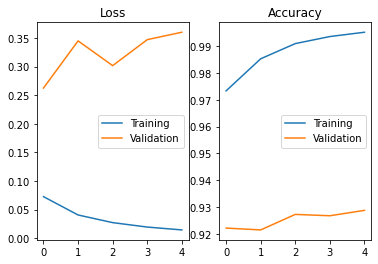

In [49]:
plot_loss_acc(overall_train_loss, overall_val_loss, overall_train_acc, overall_val_acc)

In [50]:
test_labels_predicted = []
with torch.no_grad():
    for x, label in tqdm(test_iterator, desc=f"testing", leave=False):
        x = x.to(device)
        label = label.to(device)

        x = x.float() 
        label = label.long()

        y = model(x)
        
        test_labels_predicted.append(y)



In [51]:
number_to_stance = {
    0: "agree",
    1: "disagree",
    2: "discuss",
    3: "unrelated"
}
test_stances = []

for label in test_labels:
    test_stances.append(number_to_stance[int(label)])


In [59]:
test_stances_pred = []
print(test_labels_predicted[0].shape)
for i in test_labels_predicted:
    for j in i:
        top_pred = j[0].argmax(0, keepdim=True)
        test_stances_pred.append(number_to_stance[top_pred.item()])
        

torch.Size([32, 1, 4])


In [60]:
print(len(test_stances_pred) == len(test_stances))

True


In [61]:
score.report_score(test_stances, test_stances_pred)

-------------------------------------------------------------
|           |   agree   | disagree  |  discuss  | unrelated |
-------------------------------------------------------------
|   agree   |    934    |    24     |    844    |    101    |
-------------------------------------------------------------
| disagree  |    263    |    28     |    325    |    81     |
-------------------------------------------------------------
|  discuss  |    728    |    40     |   3444    |    252    |
-------------------------------------------------------------
| unrelated |    783    |    150    |   1849    |   15567   |
-------------------------------------------------------------
Score: 8853.75 out of 11651.25	(75.98970067589315%)


75.98970067589315

In [62]:
torch.save(model.state_dict(), 'mlp-model.pt')